In [1]:
# Import important libraries
import geopandas as gpd
import numpy as np
import os
from shapely.geometry import Point, Polygon, shape
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
from shapely.ops import unary_union
import random
from scipy.spatial import cKDTree
import networkx as nx
from rasterio import features
import pandas as pd
import rasterio
from geopandas.tools import sjoin


In [2]:
# Get current path
path = os.getcwd()

# Define file paths
path_tiff = os.path.join(path, "Salinity_raster_data.tif")
path_districts = os.path.join(path, "Districts_Mekong_delta.shp")

gdf_districts = gpd.read_file(path_districts)

# Open raster
with rasterio.open(path_tiff) as src:
    raster_data = src.read(1)
    transform = src.transform
    nodata = src.nodata  

    geometries = []
    values = []

    for geom, value in features.shapes(raster_data, transform=transform):
        if value != nodata and value is not None:
            geometries.append(shape(geom))
            values.append(value)

raster_gdf = gpd.GeoDataFrame({'geometry': geometries, 'value': values}, crs="EPSG:32648")

print(raster_gdf.head())


                                            geometry     value
0  POLYGON ((432595.449 1243484.415, 432595.449 1...  6.313435
1  POLYGON ((433592.836 1243484.415, 433592.836 1...  6.285407
2  POLYGON ((434590.222 1243484.415, 434590.222 1...  6.257163
3  POLYGON ((435587.609 1243484.415, 435587.609 1...  6.228705
4  POLYGON ((436584.995 1243484.415, 436584.995 1...  6.200034


In [3]:
gdf_districts = gdf_districts[['geometry', 'Ten_Huyen']]
gdf_districts = gdf_districts.to_crs("EPSG:32648")

# save as new dataframe
# gdf_districts.to_file("district_boundaries.gpkg", driver="GPKG")

In [4]:
district_overview = set(gdf_districts['Ten_Huyen'])
district_overview

{'An Biên',
 'An Minh',
 'An Phu',
 'Ba Tri',
 'Ben Luc',
 'Ben Tre',
 'Binh Dai',
 'Binh Thuy',
 'BÌnh Chánh',
 'Bình Minh',
 'Bình Tân',
 'Cai Rang',
 'Can Duoc',
 'Can Giuoc',
 'Cang Long',
 'Cao Lanh',
 'Cau Ke',
 'Cau Ngang',
 'Chau Doc',
 'Chau Phu',
 'Chau Thanh',
 'Chau Thanh A',
 'Cho Lach',
 'Cho Moi',
 'Châu Thành',
 'Chợ Gạo',
 'Co Do',
 'Cái Bè',
 'Cái Lậy',
 'Cái Nước',
 'Cù Lao Dung',
 'Cần Giờ',
 'Củ Chi',
 'Dam Doi',
 'Duc Hoa',
 'Duc Hue',
 'Duyên Hải',
 'Giang Thanh',
 'Giong Rieng',
 'Giong Trom',
 'Giá Rai',
 'Go Quao',
 'Gò Công',
 'Gò Công Tây',
 'Gò Công Đông',
 'Ha Tien',
 'Hon Dat',
 'Hong Dan',
 'Hong Ngu',
 'Hooc Môn',
 'Hòa BÌnh',
 'Ke Sach',
 'Kien Hai',
 'Kien Luong',
 'Kien Tuong',
 'Lai Vung',
 'Lap Vo',
 'Long Hổ',
 'Long Mỹ',
 'Long Phú',
 'Long Xuyen',
 'Mang Thít',
 'Mo Cay Bac',
 'Mo Cay Nam',
 'Moc Hoa',
 'My Xuyen',
 'Mỹ Tho',
 'Mỹ Tú',
 'Nam Căn',
 'Nga Bay',
 'Ngoc Hien',
 'Ngã Năm',
 'Nhà Bè',
 'Ninh Kieu',
 'O Mon',
 'Phong Dien',
 'Phu Quoc'

In [5]:
salinity_per_commune = gpd.sjoin(raster_gdf, gdf_districts, how="inner", predicate="intersects")
salinity_per_commune = salinity_per_commune[['geometry', 'value', 'Ten_Huyen']]
salinity_per_commune = salinity_per_commune.rename(columns = {"value":"Salinity","Ten_Huyen":"District"})
salinity_per_commune

,geometry,Salinity,District
215,"POLYGON ((647033.552 1243484.415, 647033.552 1...",1.112647,Trang Bang
216,"POLYGON ((648030.938 1243484.415, 648030.938 1...",0.083040,Trang Bang
217,"POLYGON ((649028.325 1243484.415, 649028.325 1...",0.269801,Trang Bang
218,"POLYGON ((650025.711 1243484.415, 650025.711 1...",0.686780,Trang Bang
505,"POLYGON ((647033.552 1242486.229, 647033.552 1...",1.709326,Trang Bang
...,...,...,...
90513,"POLYGON ((481467.389 932050.552, 481467.389 93...",24.695301,Ngoc Hien
90801,"POLYGON ((479472.616 931052.367, 479472.616 93...",24.087433,Ngoc Hien
90802,"POLYGON ((480470.002 931052.367, 480470.002 93...",24.252684,Ngoc Hien
90804,"POLYGON ((482464.775 931052.367, 482464.775 93...",24.601704,Ngoc Hien


In [6]:
# salinity_per_commune.to_file("districts_salinity.gpkg", driver="GPKG")

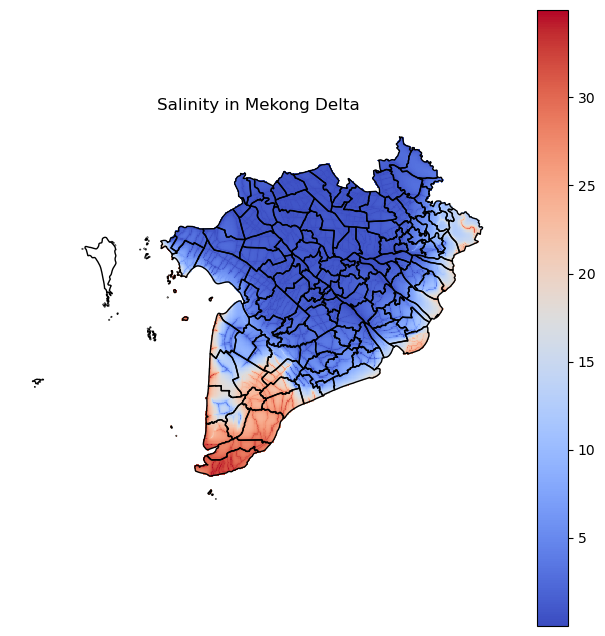

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
gdf_districts.boundary.plot(ax=ax, color='black', linewidth=1)
salinity_per_commune.plot(ax=ax, column="Salinity", cmap="coolwarm", legend=True)
plt.title("Salinity in Mekong Delta")
plt.axis("off")
plt.show()


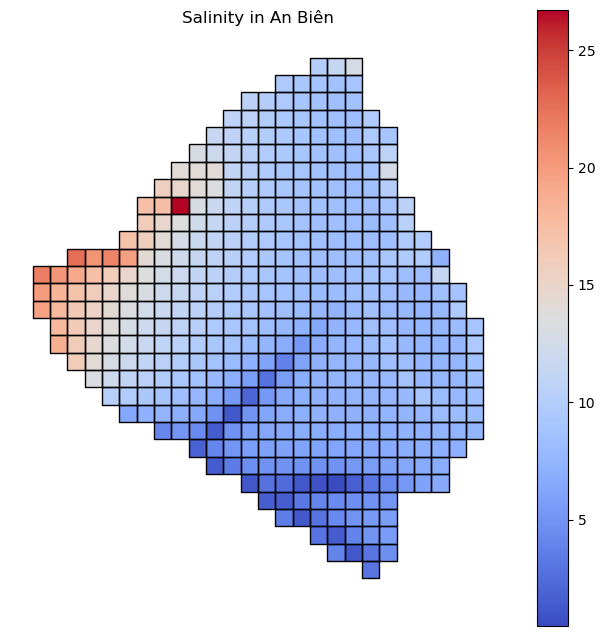

In [11]:
district_name = "An Biên"
district_gdf = salinity_per_commune[salinity_per_commune["District"] == district_name]

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
district_gdf.boundary.plot(ax=ax, color='black', linewidth=1)
district_gdf.plot(ax=ax, column="Salinity", cmap="coolwarm", legend=True)
plt.title(f"Salinity in {district_name}")
plt.axis("off")
plt.show()



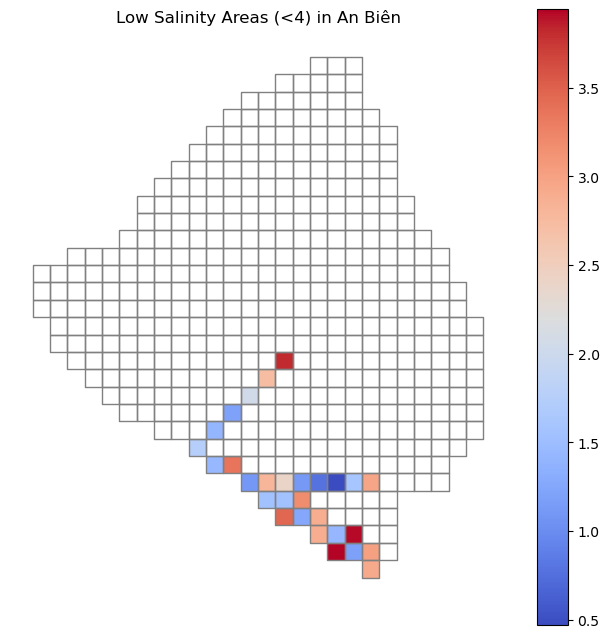

In [13]:
district_name = "An Biên"

# Filter eerst het district
district_gdf = salinity_per_commune[salinity_per_commune["District"] == district_name]

# Daarna filter je binnen dat district op salinity < 4
low_salinity_gdf = district_gdf[district_gdf["Salinity"] < 4]

# Plotten
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

# District contour als referentie
district_gdf.boundary.plot(ax=ax, color='grey', linewidth=1)

# Alleen lage salinity invullen
low_salinity_gdf.plot(ax=ax, column="Salinity", cmap="coolwarm", legend=True)

plt.title(f"Low Salinity Areas (<4) in {district_name}")
plt.axis("off")
plt.show()
